In [19]:
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
import importlib

from Bio import SeqIO
from Bio.SeqUtils.ProtParam import ProteinAnalysis

import os, subprocess, glob, re, gzip, math, shutil, itertools, sys, time, math, string
sys.path.append('scripts/') 
import jupyter_utils
from plot_tools import make_dist_plots_w_hue
sys.path.append('protocols/')

# Pyrosetta can be obtained here: https://www.pyrosetta.org/downloads
import pyrosetta
import pyrosetta.distributed.io as io
import pyrosetta.distributed.packed_pose as packed_pose
import pyrosetta.distributed.tasks.rosetta_scripts as rosetta_scripts
import pyrosetta.distributed.tasks.score as score
pyrosetta.init('-mute all')

import design_monomer
import design_cage

PyRosetta-4 2019 [Rosetta PyRosetta4.conda.linux.CentOS.python36.Release 2019.23+release.b0c18bd01c0dd36a5d94675dd95403c4077125d2 2019-06-07T13:40:47] retrieved from: http://www.pyrosetta.org
(C) Copyright Rosetta Commons Member Institutions. Created in JHU by Sergey Lyskov and PyRosetta Team.


## Directories and executables

In [20]:
### Executables

# https://www.rosettacommons.org/software/license-and-download 
rosexe = 'ROSETTA_PATH/main/source/bin/rosetta_scripts.hdf5.linuxgccrelease'

# https://github.com/rdkibler/superfold_public
superfold_exe = '/software/lab/superfold/superfold' 

# https://pymol.org/
pymol = '/usr/bin/pymol' 

# Apptainer, https://files.ipd.uw.edu/pub/protein-backbone-MCTS/protein-backbone-MCTS.sif
RL_apptainer = 'protein-backbone-MCTS.sif' 

# Sequence profile generator, https://github.com/LongxingCao/profile_prediction
profileMaker_script = 'scripts/profile_prediction/profile_prediction.py'

In [21]:
### directories
run_dir = 'test/'   
current_dir = os.getcwd()  

# backbones resulting from the RL generator ()
original_docks = run_dir + 'scaffolds/*/*pdb'

# extracted chain A from the RL generator
chA_dir = run_dir + 'input/chain_A'
extracted_interfaces_dir = run_dir + 'input/small_pdbs'

# rainity_pssms
chA_pssm_dir = run_dir + 'pssm/pssm_rainity_final_chA'
int_pssm_dir = run_dir + 'pssm/pssm_rainity_final_int'

# designed monomers
designed_monomers_dir = run_dir + 'out/designed_chA'

# all designed monomers
designed_monomers_all_dir = run_dir + 'out/designed_chA_all' 

# designed monomers that pass structure score filters
filtered_designed_monomers_dir = run_dir + 'out/filtered_designed_chA'

# AF_predicted_monomers (AF = Alphafold2)
AF_monomers_dir = run_dir + 'AF/designed_chA_AF'

# aligned DM monomers
aligned_DM_monomers_dir = run_dir + 'monomers_fordesign/aligned_DM_chA'

#aligned AF monomers
aligned_AF_monomers_dir = run_dir + 'monomers_fordesign/aligned_AF_chA'

# cage design for DM round #1 
predesigned_DM_cages_dir = run_dir + 'cage_design/1st_DM'

# all DM cages chA
predesigned_DM_cages_all_chA_dir = run_dir + 'cage_design/1st_DM_chA_all'

#cage design for AF round #1 
predesigned_AF_cages_dir = run_dir + 'cage_design/1st_AF'
#all AF cages chA
predesigned_AF_cages_all_chA_dir = run_dir + 'cage_design/1st_AF_chA_all'

#interfaces DM
extracted_DM_interfaces_dir = run_dir + 'cage_design/1st_DM_interfaces'

#interfaces AF
extracted_AF_interfaces_dir = run_dir + 'cage_design/1st_AF_interfaces'

# scores
sc_dir = 'scores'
os.makedirs(sc_dir,exist_ok=True)

## Prepare scaffolds for design

In [6]:
#################################################################################
# generate bash cmd file to extract chain A and chains surrounding chain A
#################################################################################

# scaffolds for design
original_docks = glob.glob(run_dir + 'scaffolds/*/*pdb')
print(len(original_docks))

os.makedirs(chA_dir, exist_ok=True)
os.makedirs(extracted_interfaces_dir, exist_ok=True)
os.makedirs('cmds',exist_ok=True)
cmdsfile = 'cmds/cmds_extract_chains'
with open(cmdsfile, 'w') as f_out:
    for pdb in original_docks:
        cmd = f"/usr/bin/pymol -c scripts/extract_chains.py --pdb_in {pdb} --pdb_out {extracted_interfaces_dir}/{pdb.split('/')[-1]}"
        f_out.write(cmd+'\n')
        
        cmd = f"/usr/bin/pymol -c scripts/extract_chains.py --only_chainA 1 --pdb_in {pdb} --pdb_out {chA_dir}/{pdb.split('/')[-1]}"
        f_out.write(cmd+'\n')

submitfile = cmdsfile+'.sh'
#jupyter_utils.make_submit_file(cmds=cmdsfile, submitfile=submitfile, group_size=100)
#p = subprocess.Popen(['sbatch', submitfile])

34


## Make Rainity PSSMs

In [221]:
# Number of input files 
pdb_chA = glob.glob(chA_dir + '/' + '*pdb')
pdb_int = glob.glob(extracted_interfaces_dir + '/' + '*pdb')
len(pdb_int), len(pdb_chA)

(34, 34)

In [208]:
cmdsfile = 'cmds/cmds_profile_gen'
os.makedirs(chA_pssm_dir, exist_ok=True)
os.makedirs(int_pssm_dir, exist_ok=True)

# Remember to conda activate the profileMaker_script python environment before running the script below
with open(cmdsfile, 'w') as f_out:
    for pdb in pdb_chA: # {pdbname.replace('.pdb','.pssm')}
        pssm_name = chA_pssm_dir + '/' + pdb.split('/')[-1][:-4] + '.pssm'
        cmd = f'python {profileMaker_script} -pdbs {pdb} -pssm_outname {pssm_name}'
        f_out.write(f'{cmd} \n')
    for pdb in pdb_int:
        pssm_name = int_pssm_dir + '/' + pdb.split('/')[-1][:-4] + '.pssm'
        cmd = f'python {profileMaker_script} -pdbs {pdb} -pssm_outname {pssm_name}'
        f_out.write(f'{cmd} \n')
        
#submitfile = cmdsfile+'.sh'
#jupyter_utils.make_submit_file(cmds=cmdsfile, submitfile=submitfile, group_size=1, mem='2G', queue='short')
#p = subprocess.Popen(['sbatch', submitfile])

In [22]:
print(f'now you should have generated a sequence profile file (pssm) for each of your starting backbones in the directories: {chA_pssm_dir} and {int_pssm_dir}, respectively.')

now you should have generated a sequence profile file (pssm) for each of your starting backbones in the directories: test/pssm/pssm_rainity_final_chA and test/pssm/pssm_rainity_final_int, respectively.


## Design the monomers with rainity pssm

In [14]:
# generate cmd file to design monomers with chA pdb and pssm file
### You need to install Rosetta and update the following two flags in the flags file appropriately:
## "-database ROSETTA_PATH/main/database" 
## "-holes:dalphaball ROSETTA_PATH/main/source/external/DAlpahBall.gcc"

###############################
current_dir = os.getcwd()

os.makedirs(designed_monomers_dir, exist_ok=True)
chA_pdbs = glob.glob(chA_dir + '/*pdb') # input pdbs (chainA)

cmdsfile = 'cmds/cmds_design_monomer'
flags = f'{current_dir}/protocols/flags'
xml = f'{current_dir}/protocols/design_monomer.xml'

with open(cmdsfile, 'w') as f_cmds:
    for pdb in chA_pdbs:
        pdbname = pdb.split('/')[-1][:-4]
        pssm_f = f'{current_dir}/{chA_pssm_dir}/{pdbname}.pssm' 
        chainA = current_dir + '/' + chA_dir + '/' + pdb.split('/')[-1]
        design_folder = f'{designed_monomers_dir}/{pdbname}'

        os.makedirs(design_folder, exist_ok=True)
            
        cmd = f'{rosexe} -s {chainA} -parser:protocol {xml} @{flags} -parser:script_vars pssm_f={pssm_f} -out:prefix {design_folder}/rainity_'
        f_cmds.write(cmd + '\n')

#submitfile = cmdsfile+'.sh'
#jupyter_utils.make_submit_file(cmds=cmdsfile, submitfile=submitfile, group_size=1, mem='2G', queue='short')
#p = subprocess.Popen(['sbatch', submitfile])

## Rosetta filter on monomers - score/res

In [23]:
### collect all score files and print to csv
score_paths = glob.glob(designed_monomers_dir + '/*/*_score.sc') 

dfs = []
for score_pathsidx, score_path in enumerate(score_paths):
    df_f = pd.read_csv(f'{score_path}',skiprows=1,delim_whitespace=True)
    directory = os.path.dirname(score_path)
    pdb_path = glob.glob(directory+'/*pdb')[0]
    df_f['pdbpath'] = pdb_path
    dfs.append(df_f)

df=pd.concat(dfs).dropna()
df.to_csv(f'{sc_dir}/all_scores_test.csv', index=False) 


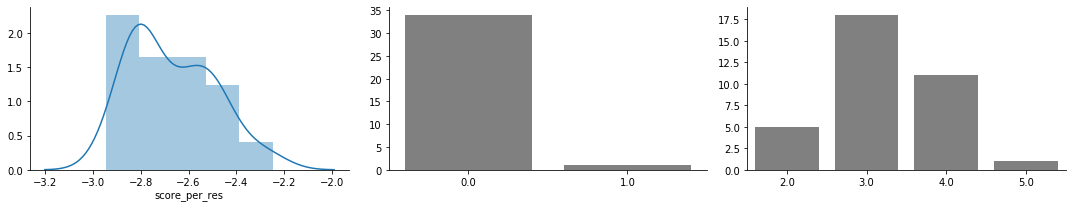

In [16]:
### plot overall distribution for key features
relevant_features = ['score_per_res','vbuns_all_heavy']
for f in relevant_features:
    df[f] = df[f].astype(float)
    
relevant_features = ['score_per_res','vbuns_all_heavy','ss_count']
make_dist_plots_w_hue(df, relevant_features)

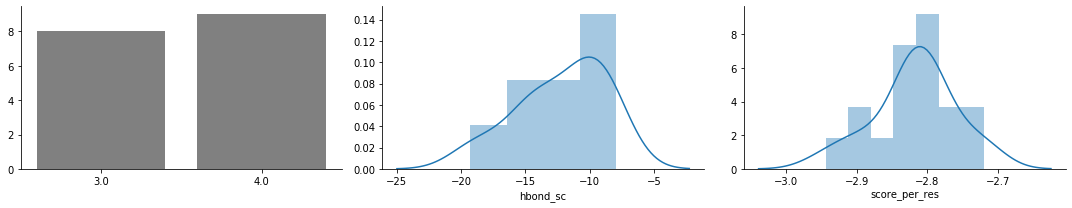

In [17]:
### filter by score_per_res, vbuns, and ss_count; and then plot distribution
dfsub = df[(df['score_per_res']<-2.7) & (df['vbuns_all_heavy']<1) & (df['ss_count']>2)]

for pdb, energy in zip(dfsub['pdbpath'], dfsub['score_per_res']):
    fname = pdb.split('/')[-1].replace('rainity_build','build')

relevant_features = ['ss_count','hbond_sc', 'score_per_res']
make_dist_plots_w_hue(dfsub, relevant_features)

In [192]:
# copy to filtered designed monomers
os.makedirs(filtered_designed_monomers_dir, exist_ok=True)
dfsub['path'] = designed_monomers_dir + '/' + dfsub['description'].str.replace("rainity_", "").str.replace("_0001", "") + '/' + dfsub['description'] + '.pdb'

for i,row in dfsub.iterrows():
    p = str(row['path'])
    d = str(row['description'])
    shutil.copy(p, f'{filtered_designed_monomers_dir}/{d}.pdb')


## Alphafold - plddt and rmsd

In [19]:
### superfold filtered designed monomers to get mean pLDDT and rmsd
chA_superfold_output_dir = run_dir + "AF/chA_superfold_output" ### new_dir
os.makedirs(chA_superfold_output_dir, exist_ok=True)

cmdsfile = 'cmds/cmds_superfold'
with open(cmdsfile, 'w') as f_out:
    f_out.write(superfold_exe)
    f_out.close()

with open(cmdsfile, 'a') as f_out:
    for pdb_AF2 in glob.glob(filtered_designed_monomers_dir + '/*pdb'):
        cmd = f"{pdb_AF2}"
        f_out.write(" " + cmd)

with open(cmdsfile, 'a') as f_out:
    f_out.write(" --out_dir " + chA_superfold_output_dir + " --models 1 --output_summary")
    f_out.close

#submitfile = cmdsfile+'.sh'
#jupyter_utils.make_submit_file(cmds=cmdsfile, submitfile=submitfile, group_size=1000, mem='2G', queue='short')
#p = subprocess.Popen(['sbatch', submitfile])

In [193]:
#### superfold results to a df
superfold_all_df = pd.read_csv(chA_superfold_output_dir + '/reports.txt', skiprows=0, sep = " |:", names = ["name","model","xx.1","recycle","xx.2","tol","xx.3","mean_plddt", "xx.4","ptM", "xx.5","rmsd","xx.6","xx.7","xx.8","xx","time"])
superfold_all_df = superfold_all_df.drop(columns=["xx","xx.1","xx.2","xx.3","xx.4","xx.5","xx.6","xx.7","xx.8"])
superfold_all_df.head()

In [21]:
### combine Rosetta metrics with AFfold to a df

df = pd.read_csv(f'{sc_dir}/all_scores_test.csv')

AF2_lDDT_dict = pd.Series(superfold_all_df['mean_plddt'].values,superfold_all_df['name']).to_dict()
AF2_rmsd_dict = pd.Series(superfold_all_df['rmsd'].values,superfold_all_df['name']).to_dict()
score_per_res_dict = pd.Series(df['score_per_res'].values,df['description'].str.split("/").str[-1]).to_dict()

df['lDDT'] = df['description'].map(AF2_lDDT_dict) 
df['rmsd'] = df['description'].map(AF2_rmsd_dict)
df['score_per_res'] = df['description'].map(score_per_res_dict)
df['AF2_path'] = chA_superfold_output_dir + '/' + df['description'] + '_model_1_ptm_seed_0_unrelaxed.pdb'

df.to_csv(f'{sc_dir}/all_scores_test.csv', index=False)


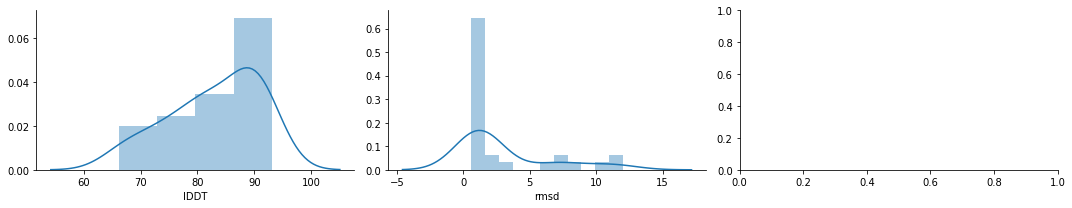

In [22]:
relevant_features = ['lDDT','rmsd']
jupyter_utils.make_dist_plots_w_hue(df[relevant_features].dropna(), relevant_features)

In [23]:
### filter monomers
dfsub = df[(df['score_per_res']<-2.7) & (df['lDDT']>80) & (df['score_per_res']<-2.7)]
dfsub['pdb_for_design'] = designed_monomers_all_dir + '/' + dfsub['description'].apply(str)
len(dfsub['pdb_for_design'])

/software/conda/envs/OBSOLETE/deepchem/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


13

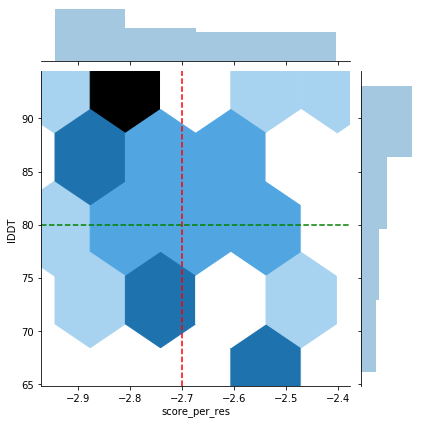

In [24]:
### plot lDDT vs. score/res
xs = df['score_per_res']
ys = df['lDDT']

plot = sns.jointplot(xs,ys, kind='hex')
plot.ax_joint.axvline(x=-2.7,linestyle='--',color='red')
plot.ax_joint.axhline(y=80,linestyle='--',color='green')

In [25]:
#copy to filtered designed monomers (AF)+(DM)
chA_superfold_output_filtered_dir = run_dir + "AF/chA_superfold_output_filtered" ### new_dir
os.makedirs(chA_superfold_output_filtered_dir, exist_ok=True)

for i,row in dfsub.iterrows():
    DM_path = str(row['pdbpath'])
    AF2_path = str(row['AF2_path'])
    d = str(row['description'])
    shutil.copy(AF2_path, f'{chA_superfold_output_filtered_dir}/{d}_AF.pdb')
    shutil.copy(DM_path, f'{chA_superfold_output_filtered_dir}/{d}_DM.pdb')


## Align monomers for cage design

In [26]:
# generate cmd to align monomer_AF and monomer_DM back to cage scaffold

os.makedirs(aligned_AF_monomers_dir, exist_ok=True)
os.makedirs(aligned_DM_monomers_dir, exist_ok=True)

cmdsfile = 'cmds/cmds_align-chA_cage'
script = f'{current_dir}/scripts/pymol_aln_n_rmsd.py'

with open(cmdsfile, 'w') as f_out:
    for i,row in dfsub.iterrows():
        DM_path = str(row['pdbpath'])
        AF2_path = str(row['AF2_path'])
        pdb_DM_name = DM_path.split('/')[-1]
        pdb_AF2_name = AF2_path.split('/')[-1]
        
        aligned_AF2_pdb = aligned_AF_monomers_dir + '/' + pdb_DM_name.split('/')[-1].replace('_0001.','_0001_AF2_aligned.')
        aligned_DM_pdb = aligned_DM_monomers_dir + '/' + pdb_DM_name.split('/')[-1].replace('_0001.','_0001_DM_aligned.')

        
        dock =  chA_dir + '/' + str(row['description']).replace('rainity_','').replace('_0001','.pdb')
        cmd1 = f"{pymol} -c {script} --input_pdb1 {AF2_path} --input_pdb2 {dock} --output_pdb {aligned_AF2_pdb}" ## align AF-models to designs
        cmd2 = f"{pymol} -c {script} --input_pdb1 {DM_path} --input_pdb2 {dock} --output_pdb {aligned_DM_pdb}" ## align AF-models to designs
                
        f_out.write(cmd1 + '\n')
        f_out.write(cmd2 + '\n')
    
#jupyter_utils.make_submit_file(cmds=cmdsfile, submitfile=submitfile, group_size=1000, mem='2G', queue='short')
#p = subprocess.Popen(['sbatch', submitfile])

## RosettaDesign cages with AF and DM monomers

In [27]:
### input chainA
Aligned_AF_chA_pdbs = glob.glob(aligned_AF_monomers_dir + '/*.pdb')
Aligned_DM_chA_pdbs = glob.glob(aligned_DM_monomers_dir + '/*.pdb')


In [28]:
# Design cage with interface pssm (DM = DesignModel)
###############################
os.makedirs(predesigned_DM_cages_dir, exist_ok=True)

xml = f'{current_dir}/scripts_protocols/design_cage/design_cage.xml'
flags = f'{current_dir}/scripts_protocols/design_cage/flags_cage_design2'

cmdsfile = 'cmds/cmds_design_cage_DM'
with open(cmdsfile, 'w') as f_cmds:
    for pdbidx, Aligned_DM_chA in enumerate(Aligned_DM_chA_pdbs):
        pdbname = Aligned_DM_chA.split('/')[-1][:-4]
        pssm_name = pdbname.replace('_0001_DM_aligned','').replace('rainity_','')
        pssm_f = f'{int_pssm_dir}/{pssm_name}.pssm'
            
        chainA = f'{aligned_DM_monomers_dir}' + '/' + Aligned_DM_chA.split('/')[-1]
        design_folder = f'{predesigned_DM_cages_dir}/{pdbname}'
        os.makedirs(design_folder, exist_ok=True)
            
        cmd = f'{rosexe} -s {chainA} -parser:protocol {xml} @{flags} -parser:script_vars pssm_f={pssm_f} -out:prefix {design_folder}/cage_' 
            
        # setup cmdfile
        f_cmds.write(f'{cmd}\n')

#submitfile = cmdsfile+'.sh'
#jupyter_utils.make_submit_file(cmds=cmdsfile, submitfile=submitfile, group_size=1, mem='8G', queue='cpu')
#p = subprocess.Popen(['sbatch', submitfile])

In [29]:
# Design cage with interface pssm (AF2_chA)
###############################
os.makedirs(predesigned_AF_cages_dir, exist_ok=True)

xml = f'{current_dir}/scripts_protocols/design_cage/design_cage.xml'
flags = f'{current_dir}/scripts_protocols/design_cage/flags_cage_design2'

cmdsfile = 'cmds/cmds_design_cage_AF2'
with open(cmdsfile, 'w') as f_cmds:
    for pdbidx, Aligned_AF_chA in enumerate(Aligned_AF_chA_pdbs):
        pdbname = Aligned_AF_chA.split('/')[-1][:-4]
        pssm_name = pdbname.replace('_0001_AF2_aligned','').replace('rainity_','')
        pssm_f = f'{int_pssm_dir}/{pssm_name}.pssm'
            
        chainA = f'{aligned_AF_monomers_dir}' + '/' + Aligned_AF_chA.split('/')[-1]
        design_folder = f'{predesigned_AF_cages_dir}/{pdbname}'
        os.makedirs(design_folder, exist_ok=True)
            
        cmd = f'{rosexe} -s {chainA} -parser:protocol {xml} @{flags} -parser:script_vars pssm_f={pssm_f} -out:prefix {design_folder}/cage_' 
            
        # setup cmdfile
        f_cmds.write(f'{cmd}\n')

#submitfile = cmdsfile+'.sh'
#jupyter_utils.make_submit_file(cmds=cmdsfile, submitfile=submitfile, group_size=1, mem='8G', queue='cpu')
#p = subprocess.Popen(['sbatch', submitfile])

## All scores: Alpha Fold, cage interfaces, and individual interfaces

#### Collect cage scores

In [173]:
# get DMcage scores
###############################
DM_score_paths = glob.glob(predesigned_DM_cages_dir + '/*/*.sc')

DM_cage_dfs = []
for score_pathsidx, score_path in enumerate(DM_score_paths):
    df_f = pd.read_csv(f'{score_path}',skiprows=1,delim_whitespace=True).tail(1) # adding tail here
                                                                                 # in case use has been
                                                                                 # writing to score.sc
                                                                                 # multiple times
    DM_cage_dfs.append(df_f)

DM_cage_dfs=pd.concat(DM_cage_dfs).dropna()
DM_cage_dfs.to_csv(f'{sc_dir}/all_cage_scores_test_DM_1st.csv', index=False)
len(DM_cage_dfs)

23

In [174]:
# get AFcage scores
###############################
AF_score_paths = glob.glob( predesigned_AF_cages_dir + '/*/*.sc')

AF_cage_dfs = []
for score_pathsidx, score_path in enumerate(AF_score_paths):
    df_f = pd.read_csv(f'{score_path}',skiprows=1,delim_whitespace=True).tail(1) # adding tail here
                                                                                 # in case use has been
                                                                                 # writing to score.sc
                                                                                 # multiple times
    AF_cage_dfs.append(df_f)

AF_cage_dfs=pd.concat(AF_cage_dfs).dropna()
AF_cage_dfs.to_csv(f'{sc_dir}/all_cage_scores_test_AF_1st.csv', index=False)
len(AF_cage_dfs)

23

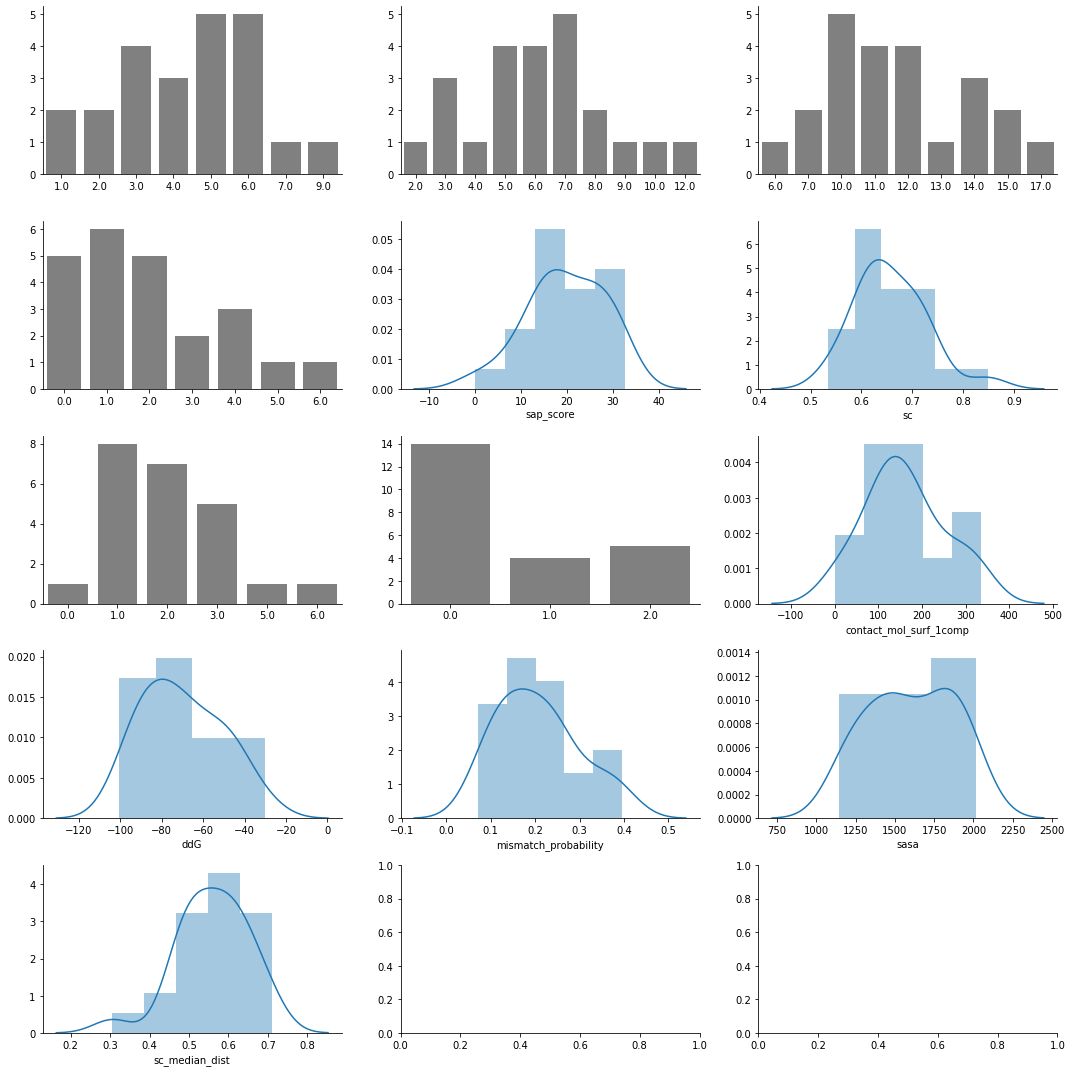

In [175]:
### check key features
relevant_features = ['AroCount','AlaCount','HPcCount','MetCount','sap_score','sc','sbuns_all_heavy','vbuns_all_heavy','contact_mol_surf_1comp','ddG','mismatch_probability','sasa','sc_median_dist']
make_dist_plots_w_hue(AF_cage_dfs, relevant_features)   ### or DM_cage_dfs

#### AlphaFold cage_monomer lDDT and rmsd

In [176]:
# extract chain A for 1st DM and 1st AF
################################################

capsid_1st_DM = glob.glob(predesigned_DM_cages_dir + '/*/*pdb')
# 1st AF designed cages
capsid_1st_AF = glob.glob(predesigned_AF_cages_dir + '/*/*pdb')

os.makedirs(predesigned_DM_cages_all_chA_dir, exist_ok=True)
os.makedirs(predesigned_AF_cages_all_chA_dir, exist_ok=True)

###### extract chain A for 1st DM
cmdsfile1 = 'cmds/cmds_extract_chA_from_designed_capsids' ###
with open(cmdsfile1, 'w') as f_out:
    for pdb in capsid_1st_DM:   ### AF
        output_dir = predesigned_DM_cages_all_chA_dir   ### AF
        cmd1 = f"{pymol} -c scripts/extract_chains.py --only_chainA 1 --pdb_in {pdb} --pdb_out {output_dir}/{pdb.split('/')[-1]}"
        f_out.write(cmd1+'\n')

###### extract chain A for 1st AF       
cmdsfile2 = 'cmds/cmds_extract_chA_from_designed_capsids' 
with open(cmdsfile2, 'a') as f_out:
    for pdb in capsid_1st_AF:
        output_dir = predesigned_AF_cages_all_chA_dir
        cmd2 = f"{pymol} -c scripts/extract_chains.py --only_chainA 1 --pdb_in {pdb} --pdb_out {output_dir}/{pdb.split('/')[-1]}"
        f_out.write(cmd2 +'\n')
                
#submitfile = cmdsfile+'.sh'
#jupyter_utils.make_submit_file(cmds=cmdsfile, submitfile=submitfile, group_size=1000)
#p = subprocess.Popen(['sbatch', submitfile])

In [177]:
### superfold filtered designed monomers to get mean pLDDT and rmsd
cage_chA_superfold_output_dir = run_dir + "AF/cage_chA_superfold_output" ### new_dir
os.makedirs(cage_chA_superfold_output_dir, exist_ok=True)

cmdsfile = 'cmds/cmds_superfold'

with open(cmdsfile, 'w') as f_out:
    f_out.write(superfold_exe)
    f_out.close()

with open(cmdsfile, 'a') as f_out:
    for cage_DM_chA in glob.glob(predesigned_DM_cages_all_chA_dir + '/*pdb'):
        cmd = f"{cage_DM_chA}"
        f_out.write(" " + cmd)
        
with open(cmdsfile, 'a') as f_out:
    for cage_AF_chA in glob.glob(predesigned_AF_cages_all_chA_dir + '/*pdb'):
        cmd = f"{cage_AF_chA}"
        f_out.write(" " + cmd)

with open(cmdsfile, 'a') as f_out:
    f_out.write(" --out_dir " + cage_chA_superfold_output_dir + " --models 4 --output_summary")
    f_out.close

#### Collect AlphaFold monomer lDDT rmsd

In [178]:
### combine Rosetta metrics with AFfold to a df
superfold_cage_chA_all_df = pd.read_csv(cage_chA_superfold_output_dir + '/reports.txt', skiprows=0,engine='python', sep = " |:", names = ["name","model","xx.1","recycle","xx.2","tol","xx.3","mean_plddt", "xx.4","ptM", "xx.5","rmsd","xx.6","xx.7","xx.8","xx","time"])
superfold_cage_chA_all_df = superfold_cage_chA_all_df.drop(columns=["xx","xx.1","xx.2","xx.3","xx.4","xx.5","xx.6","xx.7","xx.8"])

DM_cage_dfs = pd.read_csv(f'{sc_dir}/all_cage_scores_test_DM_1st.csv')
AF_cage_dfs = pd.read_csv(f'{sc_dir}/all_cage_scores_test_AF_1st.csv')

frames = [AF_cage_dfs, DM_cage_dfs]
all_cage_dfs = pd.concat(frames)

AF2_model_dict = pd.Series(superfold_cage_chA_all_df['model'].values,superfold_cage_chA_all_df['name']).to_dict()
AF2_lDDT_dict = pd.Series(superfold_cage_chA_all_df['mean_plddt'].values,superfold_cage_chA_all_df['name']).to_dict()
AF2_rmsd_dict = pd.Series(superfold_cage_chA_all_df['rmsd'].values,superfold_cage_chA_all_df['name']).to_dict()
AF2_ptM_dict = pd.Series(superfold_cage_chA_all_df['ptM'].values,superfold_cage_chA_all_df['name']).to_dict()
AF2_tol_dict = pd.Series(superfold_cage_chA_all_df['tol'].values,superfold_cage_chA_all_df['name']).to_dict()

all_cage_dfs['model'] = all_cage_dfs['description'].map(AF2_model_dict)
all_cage_dfs['lDDT'] = all_cage_dfs['description'].map(AF2_lDDT_dict) 
all_cage_dfs['rmsd'] = all_cage_dfs['description'].map(AF2_rmsd_dict)
all_cage_dfs['ptM'] = all_cage_dfs['description'].map(AF2_ptM_dict)
all_cage_dfs['tol'] = all_cage_dfs['description'].map(AF2_tol_dict)
all_cage_dfs['AF2_path'] = cage_chA_superfold_output_dir + '/' + all_cage_dfs['description'] + '_'+ all_cage_dfs['model'] + '_unrelaxed.pdb'

all_cage_dfs.to_csv(f'{sc_dir}/all_cage_scores_test.csv', index=False)


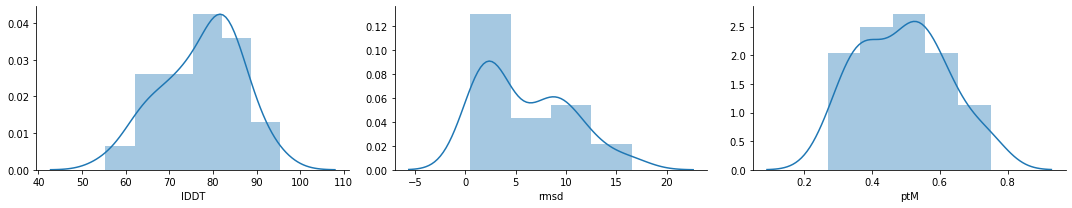

In [179]:
relevant_features = ['lDDT','rmsd','ptM']
make_dist_plots_w_hue(all_cage_dfs, relevant_features)

#### Score and filter on individual vs interfaces

In [181]:
extracted_DM_interfaces_dir = predesigned_DM_cages_all_chA_dir + '/interfaces/'
extracted_AF_interfaces_dir = predesigned_AF_cages_all_chA_dir + '/interfaces/'
extracted_AF_interfaces_dir, extracted_DM_interfaces_dir

('test/cage_design/1st_AF_chA_all/interfaces/',
 'test/cage_design/1st_DM_chA_all/interfaces/')

In [182]:
# Each subunit can make C2, C3, and C5 interfaces. To assemble the capsid 
# we want as minimum two interfaces to be good. To filter for this we must
# score them individually. The code below extracts the C2, C3, and C5 
# interface for each capsid. We score them later.

cmds = 'cmds/cmds_find_interfaces' 
with open(cmds, 'w') as f_out:
    f_out.write('cd scripts_protocols/find_score_interfaces; ')
    f_out.write(f'apptainer run {RL_apptainer} find_interface_types.py \n')

In [183]:
#### score DM interfaces with Rosetta (dimer/trimer/pentamers)
outdir = extracted_DM_interfaces_dir + '/scored'
os.makedirs(outdir, exist_ok=True)

extracted_DM_interfaces = glob.glob(extracted_DM_interfaces_dir + '/*.pdb')
protocol = 'protocols/score_interfaces.xml'
flags = 'protocols/flags_score_interface'

cmdsfile = 'cmds/cmds_score_interfaces_DM'
with open(cmdsfile, 'w') as f_cmds:
    for pdbidx, interface in enumerate(extracted_DM_interfaces):
        pdbname = interface.split('/')[-1][:-4]
        input_pdb = f'{extracted_DM_interfaces_dir}' + '/' + interface.split('/')[-1]
        sc_folder = f'{outdir}/{pdbname}/'
        os.makedirs(sc_folder, exist_ok=True)
        
        cmd = f'{rosexe} -s {input_pdb} -parser:protocol {protocol} @{flags} -out:prefix {sc_folder}'             
        f_cmds.write(cmd + '\n')

#submitfile = cmdsfile+'.sh'
#jupyter_utils.make_submit_file(cmds=cmdsfile, submitfile=submitfile, group_size=1, mem='6G', queue='cpu')
#p = subprocess.Popen(['sbatch', submitfile])

In [54]:
#### score AF interfaces (dimer/trimer/pentamers)
outdir = extracted_AF_interfaces_dir
os.makedirs(outdir, exist_ok=True)

extracted_AF_interfaces = glob.glob(extracted_AF_interfaces_dir + '/*.pdb')
protocol = 'protocols/score_interfaces.xml'
flags = 'protocols/flags_score_interface'

cmdsfile = 'cmds/cmds_score_interfaces_AF'
with open(cmdsfile, 'w') as f_cmds:
    for pdbidx, interface in enumerate(extracted_AF_interfaces):
        pdbname = interface.split('/')[-1][:-4]
        input_pdb = f'{extracted_AF_interfaces_dir}' + '/' + interface.split('/')[-1]
        sc_folder = f'{outdir}/scored/{pdbname}/'
        os.makedirs(sc_folder, exist_ok=True)
        
        cmd = f'{rosexe} -s {input_pdb} -parser:protocol {xml} @{flags} -out:prefix {sc_folder}'             
        f_cmds.write(cmd + '\n')

#submitfile = cmdsfile+'.sh'
#jupyter_utils.make_submit_file(cmds=cmdsfile, submitfile=submitfile, group_size=5, mem='6G', queue='cpu')
#p = subprocess.Popen(['sbatch', submitfile])

In [184]:
#### combine dimer/trimer/pentamer in one df

AF_score_paths = glob.glob( extracted_AF_interfaces_dir + '/scored/*_trimer/score.sc')
DM_score_paths = glob.glob( extracted_DM_interfaces_dir + '/scored/*_trimer/score.sc')

print(f'Found {len(AF_score_paths)} score files in AF_score_paths')
print(f'Found {len(DM_score_paths)} score files in DM_score_paths')

score_paths =  DM_score_paths + AF_score_paths

def get_name(s):
    return '_'.join(s.split('/')[-1].split('_')[:-2])

dfs = []
for score_pathsidx, score_path in enumerate(score_paths):   
    # Dimers
    dimer_f = score_path.replace('trimer','dimer')
    df_2 = pd.read_csv(f'{dimer_f}',skiprows=1,delim_whitespace=True).tail(1)
    new_name_map = {x:x+'_2' for x in df_2.columns}
    df_2 = df_2.rename(columns=new_name_map)
    df_2['name'] = df_2.apply(lambda x: get_name(x['description_2']), axis=1)
    
    # Trimers
    trimer_f = score_path
    df_3 = pd.read_csv(f'{trimer_f}',skiprows=1,delim_whitespace=True).tail(1)
    new_name_map = {x:x+'_3' for x in df_3.columns}
    df_3 = df_3.rename(columns=new_name_map)
    df_3['name'] = df_3.apply(lambda x: get_name(x['description_3']), axis=1)

    # Pentamers
    pentamer_f = score_path.replace('trimer','pentamer')
    df_5 = pd.read_csv(f'{pentamer_f}',skiprows=1,delim_whitespace=True).tail(1)
    new_name_map = {x:x+'_5' for x in df_5.columns}
    df_5 = df_5.rename(columns=new_name_map)
    df_5['name'] = df_5.apply(lambda x: get_name(x['description_5']), axis=1)
    
    # Merge all the data   
    df_merge = df_2.merge(df_3)    
    df_merge = df_merge.merge(df_5)
    dfs.append(df_merge)

df_combined = pd.concat(dfs)

print(f'Got complete C2, C3, and C5 score sets for {len(df_combined)} pdbs ')
df_combined.to_csv(f'{sc_dir}/all_interface_scores_test.csv', index=False)

Found 23 score files in AF_score_paths
Found 23 score files in DM_score_paths
Got complete C2, C3, and C5 score sets for 46 pdbs 


#### Combine all scores (cage_monomer_interfaces) in 1 file

In [185]:
### combine all scores
df = pd.read_csv(f'{sc_dir}/all_interface_scores_test.csv')

All_scores_df = pd.read_csv(f'{sc_dir}/all_cage_scores_test.csv')

ddG2_dict = pd.Series(df['ddg_2'].values,df['name']).to_dict()
ddG3_dict = pd.Series(df['ddg_3'].values,df['name']).to_dict()
ddG5_dict = pd.Series(df['ddg_5'].values,df['name']).to_dict()

cms2_dict = pd.Series(df['contact_molecular_surface_2'].values,df['name']).to_dict()
cms3_dict = pd.Series(df['contact_molecular_surface_3'].values,df['name']).to_dict()
cms5_dict = pd.Series(df['contact_molecular_surface_5'].values,df['name']).to_dict()

cms_ap2_dict = pd.Series(df['contact_molecular_surface_ap_target_2'].values,df['name']).to_dict()
cms_ap3_dict = pd.Series(df['contact_molecular_surface_ap_target_3'].values,df['name']).to_dict()
cms_ap5_dict = pd.Series(df['contact_molecular_surface_ap_target_5'].values,df['name']).to_dict()

All_scores_df['cms_2'] = All_scores_df['description'].map(cms2_dict)
All_scores_df['cms_3'] = All_scores_df['description'].map(cms3_dict)
All_scores_df['cms_5'] = All_scores_df['description'].map(cms5_dict)
All_scores_df['cms-ap_2'] = All_scores_df['description'].map(cms_ap2_dict)
All_scores_df['cms-ap_3'] = All_scores_df['description'].map(cms_ap3_dict)
All_scores_df['cms-ap_5'] = All_scores_df['description'].map(cms_ap5_dict)
All_scores_df['ddG_2'] = All_scores_df['description'].map(ddG2_dict)
All_scores_df['ddG_3'] = All_scores_df['description'].map(ddG3_dict)
All_scores_df['ddG_5'] = All_scores_df['description'].map(ddG5_dict) 

All_scores_df.to_csv(f'{sc_dir}/all_scores_test_1stround.csv', index=False)

#### Filtering all metrics

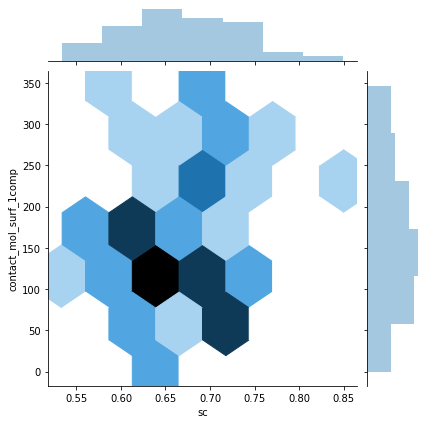

In [186]:
All_scores_df = pd.read_csv(f'{sc_dir}/all_scores_test_1stround.csv')
assert len(All_scores_df) == len(All_scores_df.dropna())
g = sns.jointplot(All_scores_df['sc'],All_scores_df['contact_mol_surf_1comp'], kind='hex')

In [187]:
#relevant_features = ['binder_delta_sap', 'target_delta_sap', 'contact_molecular_surface', 'contact_molecular_surface_ap_target','contact_molec_sq5_ap_target','ddg', 'interface_buried_sasa','interface_sc','ss_sc','score_per_res', 'interface_sc_median_dist']

All_scores_df['total_ddg'] = All_scores_df['ddG_2'] + All_scores_df['ddG_3']*2 + All_scores_df['ddG_5']*2

# Criteria for ONE good interfaces "cms = contact_molecular_surface" "cms-ap = contact_molecular_surface_ap_target"
feature2cutoff = {'ddG': -20, \
                  'cms': 180, \
                  'cms-ap': 100} 

feature2direction = {'ddG': '<', \
                     'cms': '>', \
                     'cms-ap': '>'}

def calc_n_good_interfaces(row):
    n_good = 0
    for interface in ['_2', '_3', '_5']:
        criteria_passed = 0
        for feature_name in feature2cutoff:
            greaterThan = (feature2direction[feature_name]=='>')
            feature_name_for_interface = feature_name + interface
            feature_score = row[feature_name_for_interface]
            if greaterThan:
                is_feature_passing = (feature_score > feature2cutoff[feature_name])
            else:
                is_feature_passing = (feature_score < feature2cutoff[feature_name])
            criteria_passed += int(is_feature_passing)
        is_good = (len(feature2cutoff) == criteria_passed)
        n_good += int(is_good)
    return n_good

All_scores_df['n_good_interfaces'] = All_scores_df.apply(lambda x: calc_n_good_interfaces(x), axis=1)

#### cage individual interface metrics
All_scores_df_filtered = All_scores_df[  (All_scores_df['n_good_interfaces']>=2)\
                 
#### AF metrics        ###90  ###1         
& (All_scores_df['lDDT'] >85)\
& (All_scores_df['rmsd']<2)\

                 
#### cage interface metrics   ###30   ###4  ###4   ###0.6
& (All_scores_df['sap_score']<30)\
& (All_scores_df['sbuns_all_heavy'] <3)\
& (All_scores_df['vbuns_all_heavy'] <3)\
& (All_scores_df['sc'] >0.63)\
                 
                ]
# If we see that they have a lot of apolar surface area we could filter on solvent_exposed_sap as well.
print(f'Designs passing filters {len(All_scores_df_filtered)}')


Designs passing filters 2


In [203]:
all_designs = glob.glob('test/cage_design/1st_??/*/*pdb')

print('The passing pdbs can be found here:\n')
description2designPath = {f.split('/')[-1][:-4]:f for f in all_designs}
for description in All_scores_df_filtered['description']:
    print(description2designPath[description])

The passing pdbs can be found here:

test/cage_design/1st_DM/rainity_build_0.2089_0.98_0.4653_19_2.00_0.005745_0001_DM_aligned/cage_rainity_build_0.2089_0.98_0.4653_19_2.00_0.005745_0001_DM_aligned_0001.pdb
test/cage_design/1st_DM/rainity_build_0.2222_1.0_0.5092_24_2.15_0.615602_0001_DM_aligned/cage_rainity_build_0.2222_1.0_0.5092_24_2.15_0.615602_0001_DM_aligned_0001.pdb


In [207]:
print("Next up: Order and see if your designs work. Good luck!")

Next up: Order and see if your designs work. Good luck!
